# Credit Curves Fundamentals

This notebook demonstrates how to access and use the **Credit Curves** functionalities within the **LSEG Financial Analytics SDK**. 

Credit curves represent the relationship between the credit risk of an entity (such as a corporation or government) and the time to maturity of its debt instruments. They show how credit spreads or default probabilities change over different maturities, helping investors and risk managers assess the cost of credit protection and the likelihood of default over time. In financial analytics, credit curves are essential for pricing credit derivatives, managing portfolio risk, and evaluating counterparty creditworthiness.

**You will be able to:**
- Credit Curve with basic parameters
- Configure pricing parameters
- Evaluate Credit Curves Analytics

## Imports

Import the following necessary modules:

- `lseg_analytics.pricing.market_data` - for Credit Curve data construction

This notebook uses external libraries **pandas, matplotlib, IPython**; please ensure they are installed in your Python environment (e.g. 'pip install pandas') before running the code.

In [1]:
from lseg_analytics.pricing.market_data import credit_curves as cc

from lseg_analytics.pricing.market_data.credit_curves import create, delete, overwrite, read, search

from lseg_analytics.pricing.market_data.credit_curves import (
    CreditCurveParameters,
    CalibrationParameters,
    CreditCurveRequestItem,
    CreditCurveDefinition,
    CalibrationModelEnum,
    ExtrapolationTypeEnum,
    CalendarAdjustmentEnum,
    IssuerTypeEnum,
    RatingScaleSourceEnum,
    CurveSubTypeEnum,
    )

import pandas as pd

import json
import datetime as dt
from IPython.display import display
import matplotlib.pyplot as plt

## Government Credit Curve

## Data Preparation

To define a Credit Curve instrument you need to follow a process:

1. **Credit Curve Definition** - Specify Issuer parameters (Issuer, Issuer Type, Country, Currency)
2. **Credit Curve Parameters** - Specify Curve parameters (Date, Calibartion Model, Calibration Parameters)

In [2]:
print("Step 1: Configuring Curve Definition...")

curve_definition = CreditCurveDefinition(
    name = "Belgium GOV Par Benchmark Curve", # combination of Name | Country | Currency | isCurrencyCountryOriginator, see Appendix 2 below
    issuer_type = IssuerTypeEnum.SOVEREIGN,
    country = "BE",
    source = RatingScaleSourceEnum.REFINITIV,
    currency = "EUR",
    curve_sub_type=CurveSubTypeEnum.GOVERNMENT_BENCHMARK,
    is_currency_country_originator=True
)

print(f"   Curve Name: {curve_definition.name}")


print("Step 2: Configuring Curve Parameters...")


curve_parameters = CreditCurveParameters(
    valuation_date = dt.date(2025, 9, 19), # remove valuation_date to get a real-time
    calibration_model = CalibrationModelEnum.BASIS_SPLINE,
    calibration_parameters = CalibrationParameters(
        is_monotonic = True,
        extrapolation_points_number = 4,
        extrapolation_type = ExtrapolationTypeEnum.EXTRAPOLATION_RIGHT_FLAT
    ),
    use_duration_weighted_minimization = True,
    use_multi_dimensional_solver = True,
    calendar_adjustment = CalendarAdjustmentEnum.CALENDAR,
    use_delayed_data_if_denied = False
)

print(f"   Curve Parameters: {curve_parameters}")


print("Step 3: Create request item...")

credit_curve_request = CreditCurveRequestItem(
    curve_parameters = curve_parameters,
    curve_definition = curve_definition,
    constituents = None # default set of constituents is used, i.e. no bonds are filtered by maturity/notional/etc
)

print(f"   Request: {json.dumps(credit_curve_request.as_dict(), indent=4)}")

Step 1: Configuring Curve Definition...
   Curve Name: Belgium GOV Par Benchmark Curve
Step 2: Configuring Curve Parameters...
   Curve Parameters: {'valuationDate': '2025-09-19', 'calibrationModel': 'BasisSpline', 'calibrationParameters': {'isMonotonic': True, 'extrapolationPointsNumber': 4, 'extrapolationType': 'ExtrapolationRightFlat'}, 'useDurationWeightedMinimization': True, 'useMultiDimensionalSolver': True, 'calendarAdjustment': 'Calendar', 'useDelayedDataIfDenied': False}
Step 3: Create request item...
   Request: {
    "curveParameters": {
        "valuationDate": "2025-09-19",
        "calibrationModel": "BasisSpline",
        "calibrationParameters": {
            "isMonotonic": true,
            "extrapolationPointsNumber": 4,
            "extrapolationType": "ExtrapolationRightFlat"
        },
        "useDurationWeightedMinimization": true,
        "useMultiDimensionalSolver": true,
        "calendarAdjustment": "Calendar",
        "useDelayedDataIfDenied": false
    },
 

## Request Execution

In [3]:
# Get the constituents
try:
    response_constituents = cc.calculate(universe=[credit_curve_request], fields="Constituents")
    print("Credit curve calculation completed")
except Exception as e:
    print("Error during credit curve calculation:", str(e))

# Get the curve
try:
    response = cc.calculate(universe=[credit_curve_request])
    print("Credit curve calculation completed")
except Exception as e:
    print("Error during credit curve calculation:", str(e))

Credit curve calculation completed
Credit curve calculation completed


## Results Display

### Key Sections in `response` JSON

 - **curveParameters**: Date, Calendars, Interpolation mode, Extrapolation mode, Calibration model, etc

 - **curveDefinition**: Name, Reference Entity, Issuer Type, Country, etc

 - **curvePoints**: Rates vs Tenors, Discount factors, Start and End dates of Tenor

In [4]:
# Load JSON response
response_json = json.loads(json.dumps(response.as_dict()))

response_constituents_json = json.loads(json.dumps(response_constituents.as_dict()))

### Response: Constituents

In [5]:
constituents = response_constituents_json['data'][0]['constituents']['creditInstruments']['EUR']['bonds']

df_constituents = pd.json_normalize(constituents, sep='_')
display(df_constituents)

,fields_ask_value,fields_bid_value,fields_marketDataDate,instrumentDefinition_endDate,instrumentDefinition_fixedRatePercent,instrumentDefinition_instrumentCode,instrumentDefinition_quotationMode,instrumentDefinition_startDate,instrumentDefinition_template
0,99.730,99.720,2025-09-19,2025-11-13,0.00,BE3MT=RR,PercentCleanPrice,2025-09-23,ACC:A0 CFADJ:NO CLDR:EMU_FI DMC:F EMC:S ISSUE:...
1,99.240,99.213,2025-09-19,2026-02-12,0.00,BE6MT=RR,PercentCleanPrice,2025-09-23,ACC:A0 CFADJ:NO CLDR:EMU_FI DMC:F EMC:S ISSUE:...
2,98.754,98.707,2025-09-19,2026-05-14,0.00,BE9MT=RR,PercentCleanPrice,2025-09-23,ACC:A0 CFADJ:NO CLDR:EMU_FI DMC:F EMC:S ISSUE:...
3,98.222,98.189,2025-09-19,2026-08-13,0.00,BE1YT=RR,PercentCleanPrice,2025-09-23,ACC:A0 CFADJ:NO CLDR:EMU_FI DMC:F EMC:S ISSUE:...
4,97.891,97.811,2025-09-19,2027-06-22,0.80,BE2YT=RR,PercentCleanPrice,2025-09-23,ACC:AA CCM:BBAA CFADJ:NO CLDR:EMU_FI DATED:24J...
5,96.304,96.224,2025-09-19,2028-06-22,0.80,BE3YT=RR,PercentCleanPrice,2025-09-23,ACC:AA CCM:BBAA CFADJ:NO CLDR:EMU_FI DATED:23J...
6,94.739,94.639,2025-09-19,2029-06-22,0.90,BE4YT=RR,PercentCleanPrice,2025-09-23,ACC:AA CCM:BBAA CFADJ:NO CLDR:WEEKEND DATED:15...
7,89.166,89.066,2025-09-19,2030-06-22,0.10,BE5YT=RR,PercentCleanPrice,2025-09-23,ACC:AA CCM:BBAA CFADJ:NO CLDR:WEEKEND DATED:22...
8,91.018,90.978,2025-09-19,2031-06-22,1.00,BE6YT=RR,PercentCleanPrice,2025-09-23,ACC:AA CCM:BBAA CFADJ:NO CLDR:EMU_FI DATED:17F...
9,84.707,84.607,2025-09-19,2032-06-22,0.35,BE7YT=RR,PercentCleanPrice,2025-09-23,ACC:AA CCM:BBAA CFADJ:NO CLDR:WEEKEND DATED:25...


### Response: Curve Definition

In [6]:
curveDefinition = response_json['data'][0]['curveDefinition']
df_curve_def = pd.DataFrame(curveDefinition.items(), columns=["Parameter", "Value"])
display(df_curve_def)

,Parameter,Value
0,country,BE
1,currency,EUR
2,curveSubType,GovernmentBenchmark
3,id,21c8ba29-7ed6-4907-bd56-d5663f972703
4,isCurrencyCountryOriginator,True
5,issuerType,Sovereign
6,mainConstituentAssetClass,Bond
7,name,Belgium GOV Par Benchmark Curve
8,source,Refinitiv


### Response: Curve Parameters

In [7]:
curveParameters = response_json['data'][0]['curveParameters']
df_curve_params = pd.DataFrame(curveParameters.items(), columns=["Parameter", "Value"])
valuation_date_gov = dt.datetime.strptime(curveParameters['valuationDate'], '%Y-%m-%d').date()
display(df_curve_params)

,Parameter,Value
0,calendarAdjustment,Calendar
1,calendars,[EMU_FI]
2,calibrationModel,BasisSpline
3,calibrationParameters,"{'extrapolationPointsNumber': 4, 'extrapolatio..."
4,extrapolationMode,None
5,interestCalculationMethod,Dcb_Actual_Actual
6,interpolationMode,CubicDiscount
7,priceSide,Mid
8,useDelayedDataIfDenied,False
9,useDurationWeightedMinimization,True


### Response: Curve Points

,Tenor,RatePercent
0,3M,2.001231
1,6M,2.019381
2,1Y,2.047501
3,2Y,2.134713
4,3Y,2.260055
5,4Y,2.423639
6,5Y,2.590451
7,6Y,2.757492
8,7Y,2.906267
9,8Y,3.059348


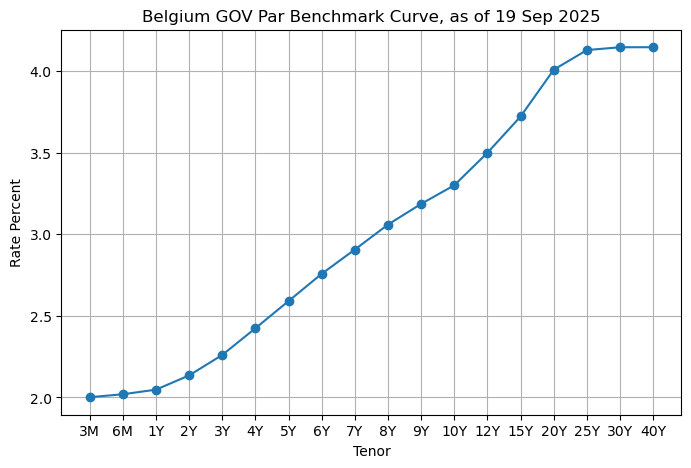

In [8]:
name = response_json["data"][0]["curveDefinition"]["name"]

curve_points = response_json["data"][0]["curvePoints"]
rate_vs_tenor = [(point["tenor"], point["ratePercent"]) for point in curve_points]
rate_vs_tenor_df = pd.DataFrame(rate_vs_tenor, columns=["Tenor", "RatePercent"])
display(rate_vs_tenor_df)

valuation_date_str = valuation_date_gov.strftime('%d %b %Y')
plt.figure(figsize=(8,5))
plt.plot(rate_vs_tenor_df['Tenor'], rate_vs_tenor_df['RatePercent'], marker='o')
plt.title(f'{name}, as of {valuation_date_str}')
plt.xlabel('Tenor')
plt.ylabel('Rate Percent')
plt.grid(True)
plt.show()

## 

# Search and CRUD (Create, Read, Update, Delete) Functions

## Create
Creates a Curve Definition and stores on a platform

In [9]:
unique_id_create_name = "SDKTest-55241" # Unique ID of Create, it can be created only once via Create function
# In case of duplicate, you will got an error:
# "Exception: Bad request: code=FinancialContract-API.InvalidInputError The service failed to create the curve definition: Such a curve definition already exists"

curve_definition_create = cc.CreditCurveDefinition(
    name=unique_id_create_name,
    issuer_type=cc.IssuerTypeEnum.SOVEREIGN,
    country="DE",
    source="LFA",
    currency="EUR",
    curve_sub_type=cc.CurveSubTypeEnum.GOVERNMENT_BENCHMARK,
    main_constituent_asset_class="Bond",
)

segments_create = [
    cc.CreditCurveInstrumentsSegment(
        constituents=cc.CreditConstituentsDescription(
            bonds=[
                cc.BondInstrumentDescription(
                    instrument_definition=cc.BondInstrumentDefinition(
                        instrument_code="DE114181=",
                        fixed_rate_percent=0.0,
                        template="ACC:AA CCM:BBAA CFADJ:NO CLDR:EMU_FI DATED:31JAN2020 DMC:F EMC:S FRCD:11APR2021 FRQ:1 ISSUE:31JAN2020 NOTIONAL:1 PX:C PXRND:1E-5:NEAR REFDATE:MATURITY RP:1 SETTLE:2WD XD:NO",
                        quotation_mode="PercentCleanPrice",
                    )
                )
            ]
        ),
        start_date=dt.date(2025, 1, 1),
    )
]

print("Creating Curve Definition...")
response_create = create(curve_definition=curve_definition_create, segments=segments_create)

print(f"   Response: {json.dumps(response_create.as_dict(), indent=4)}")

print(response_create.data.curve_definition.id)

Creating Curve Definition...
   Response: {
    "data": {
        "curveDefinition": {
            "country": "DE",
            "currency": "EUR",
            "curveSubType": "GovernmentBenchmark",
            "firstHistoricalAvailabilityDate": "2025-01-01",
            "id": "a8609860-2eec-4660-93c2-473ac8bc7ea1",
            "issuerType": "Sovereign",
            "mainConstituentAssetClass": "Bond",
            "name": "SDKTest-55241",
            "owner": "GE-SP3A4U7WBPXE",
            "riskType": "Credit",
            "source": "LFA"
        },
        "curveInfo": {
            "creationDateTime": "2025-12-03T12:45:44.891Z",
            "creationUserId": "GE-SP3A4U7WBPXE",
            "updateDateTime": "2025-12-03T12:45:44.891Z",
            "updateUserId": "GE-SP3A4U7WBPXE"
        },
        "segments": [
            {
                "constituents": {
                    "bonds": [
                        {
                            "instrumentDefinition": {
                 

## Read
Access a CreditCurveDefinition existing in the platform (read). The CreditCurveDefinition can be identified either by its unique ID (GUID format) or by its location path (space/name).

In [10]:
response_read = read(curve_id=response_create.data.curve_definition.id)

print(f"   Response: {json.dumps(response_read.as_dict(), indent=4)}")

   Response: {
    "data": {
        "curveDefinition": {
            "country": "DE",
            "currency": "EUR",
            "curveSubType": "GovernmentBenchmark",
            "firstHistoricalAvailabilityDate": "2025-01-01",
            "id": "a8609860-2eec-4660-93c2-473ac8bc7ea1",
            "issuerType": "Sovereign",
            "mainConstituentAssetClass": "Bond",
            "name": "SDKTest-55241",
            "owner": "GE-SP3A4U7WBPXE",
            "riskType": "Credit",
            "source": "LFA"
        },
        "curveInfo": {
            "creationDateTime": "2025-12-03T12:45:44.891Z",
            "creationUserId": "GE-SP3A4U7WBPXE",
            "updateDateTime": "2025-12-03T12:45:44.891Z",
            "updateUserId": "GE-SP3A4U7WBPXE"
        },
        "segments": [
            {
                "constituents": {
                    "bonds": [
                        {
                            "instrumentDefinition": {
                                "fixedRatePerc

## Overwrite
Overwrite a CreditCurveDefinition that exists in the platform. The CreditCurveDefinition can be identified either by its unique ID (GUID format) or by its location path (space/name).

In [11]:
curve_definition_overwrite = curve_definition_create
curve_definition_overwrite.country = "US"
curve_definition_overwrite.currency = "USD"

response_overwrite = overwrite(curve_id=response_create.data.curve_definition.id, 
                                  curve_definition=curve_definition_overwrite, 
                                  segments=segments_create)
print(json.dumps(response_overwrite.as_dict(), indent=4))

response_read = read(curve_id=response_create.data.curve_definition.id)
print(f"   Response: {json.dumps(response_read.as_dict(), indent=4)}") # Now it has USD and US

{
    "data": {
        "curveDefinition": {
            "country": "US",
            "currency": "USD",
            "curveSubType": "GovernmentBenchmark",
            "firstHistoricalAvailabilityDate": "2025-01-01",
            "id": "a8609860-2eec-4660-93c2-473ac8bc7ea1",
            "issuerType": "Sovereign",
            "mainConstituentAssetClass": "Bond",
            "name": "SDKTest-55241",
            "owner": "GE-SP3A4U7WBPXE",
            "riskType": "Credit",
            "source": "LFA"
        },
        "curveInfo": {
            "creationDateTime": "2025-12-03T12:45:44.891Z",
            "creationUserId": "GE-SP3A4U7WBPXE",
            "updateDateTime": "2025-12-03T12:45:48.620Z",
            "updateUserId": "GE-SP3A4U7WBPXE"
        },
        "segments": [
            {
                "constituents": {
                    "bonds": [
                        {
                            "instrumentDefinition": {
                                "fixedRatePercent": 0.0,
  

## Delete
Delete a CreditCurveDefinition that exists in the platform. The CreditCurveDefinition can be identified either by its unique ID (GUID format) or by its location path (space/name).

In [12]:
delete(curve_id=response_create.data.curve_definition.id)

True

## Search
Returns the definitions of the available curves for the filters selected

In [13]:
curve_definition_search = CreditCurveDefinition(
    issuer_type = IssuerTypeEnum.SOVEREIGN,
    source = RatingScaleSourceEnum.REFINITIV,
    currency = "EUR",
    curve_sub_type=CurveSubTypeEnum.GOVERNMENT_BENCHMARK,
)

response_search = search(universe=[curve_definition_search])


curve_defs = response_search['data'][0]['curveDefinitions']
df_curves = pd.DataFrame(curve_defs)
display(df_curves) # it is a subset of Appendix 2 for specific currency provided below

curve_definition_selected = [curve for curve in curve_defs if curve['country'] == "BE"][0]
curve_definition_selected_id = curve_definition_selected['id']

print(json.dumps(curve_definition_selected.as_dict(), indent=4))


,country,currency,curveSubType,firstHistoricalAvailabilityDate,id,isCurrencyCountryOriginator,issuerType,mainConstituentAssetClass,name,source
0,SI,EUR,GovernmentBenchmark,2022-03-29,12913f43-3b7f-4bf6-a5fa-45fd509bdf17,True,Sovereign,Bond,Slovenia GOV Par Benchmark Curve,Refinitiv
1,BE,EUR,GovernmentBenchmark,2022-03-29,21c8ba29-7ed6-4907-bd56-d5663f972703,True,Sovereign,Bond,Belgium GOV Par Benchmark Curve,Refinitiv
2,GR,EUR,GovernmentBenchmark,2022-03-29,24f7165e-613a-44fd-87ca-eaab8091aa4d,True,Sovereign,Bond,Greece GOV Par Benchmark Curve,Refinitiv
3,FI,EUR,GovernmentBenchmark,2022-03-29,4ae035c2-e4cd-455b-b9fd-b028d787a4a1,True,Sovereign,Bond,Finland GOV Par Benchmark Curve,Refinitiv
4,SK,EUR,GovernmentBenchmark,2022-03-29,4ce481d5-10df-4cfc-925f-7d9dd11f8fd8,True,Sovereign,Bond,Slovakia GOV Par Benchmark Curve,Refinitiv
5,FR,EUR,GovernmentBenchmark,2022-03-29,5017600c-c32d-4053-ad5c-d180604cfe65,True,Sovereign,Bond,France GOV Par Benchmark Curve,Refinitiv
6,PT,EUR,GovernmentBenchmark,2022-03-29,5bbb6f60-37f8-4144-ab50-8e2d23ade646,True,Sovereign,Bond,Portugal GOV Par Benchmark Curve,Refinitiv
7,DE,EUR,GovernmentBenchmark,2022-05-10,9a25c9c7-61e4-4fc8-a7f2-ee6544a69f70,True,Sovereign,Bond,Germany GOV Par Benchmark Curve,Refinitiv
8,IT,EUR,GovernmentBenchmark,2022-03-29,9ea2f3f4-ee52-4604-bd26-6bebe15d8e3f,True,Sovereign,Bond,Italy GOV Par Benchmark Curve,Refinitiv
9,NL,EUR,GovernmentBenchmark,2022-03-29,a678703d-afe6-4459-b388-3467b27a00d7,True,Sovereign,Bond,Netherlands GOV Par Benchmark Curve,Refinitiv


{
    "country": "BE",
    "currency": "EUR",
    "curveSubType": "GovernmentBenchmark",
    "firstHistoricalAvailabilityDate": "2022-03-29",
    "id": "21c8ba29-7ed6-4907-bd56-d5663f972703",
    "isCurrencyCountryOriginator": true,
    "issuerType": "Sovereign",
    "mainConstituentAssetClass": "Bond",
    "name": "Belgium GOV Par Benchmark Curve",
    "source": "Refinitiv"
}


## Appendix 1: Complete Functions Reference

The following is a list of used classes, enums, and functions available after importing from `lseg_analytics.pricing.market_data`:

**Core Classes:**
- `CreditCurveDefinition` - Define Issuer parameters
- `CreditCurveParameters` - Define Curve calibration parameters

**Response Classes:**
- `CreditCurveResponse` - Main Curve response container
- `CreditCurvesResponseItem` - Main Curve response Item
- `CreditCurveDefinitionResponse` - Definition response container
- `CreditCurveDefinitionResponseItem` - Definition Item response container

**Configuration Enums:**
- `CurveSubTypeEnum` - Curve Subtype (GOVERNMENT_BOND_BENCHMARK)
- `IssuerTypeEnum` - Issuer Type (SOVEREIGN)
- `CalibrationModelEnum` - Calibration mode (BASIS_SPLINE, NELSON_SIEGEL_SVENSSON)
- `ExtrapolationTypeEnum` - Extrapolation mode (EXTRAPOLATION_BOTH_DERIVATIVE, EXTRAPOLATION_RIGHT_FLAT, etc)
- `CalendarAdjustmentEnum` - Calendar Adjustment mode (CALENDAR, NO, WEEKEND)


**Main Functions:**
- `calculate()` - Execute calculations
- `functions_all` - List all available functions

## Appendix 2: Available Government Curves

Name | Country | Currency | isCurrencyCountryOriginator
--- | --- | --- | ---
Armenia GOV Par Benchmark Curve | AM | AMD | True
Australia GOV Par Benchmark Curve | AU | AUD | True
Australia T GOV Par Benchmark Curve | AU | AUD | False
Austria GOV Par Benchmark Curve | AT | EUR | True
Bahrain GOV Par Benchmark Curve | BH | BHD | True
Bangladesh Government Bond Zero Curve | BD | BDT | False
Belgium GOV Par Benchmark Curve | BE | EUR | True
Botswana GOV Par Benchmark Curve | BW | BWP | True
Brazil Global Government Bond Zero Curve | BR | USD | False
Brazil GOV Par Benchmark Curve | BR | BRL | True
Bulgaria GOV Par Benchmark Curve | BG | BGN | True
Canada GOV Par Benchmark Curve | CA | CAD | True
Chile CLP GOV Par Benchmark Curve | CL | CLP | True
Chile GOV Par Benchmark Curve | CL | CLF | False
China GOV Par Benchmark Curve | CN | CNY | True
Colombia Global Government Bond Zero Curve | CO | USD | False
Colombia GOV Par Benchmark Curve | CO | COP | True
Croatia GOV Par Benchmark Curve | HR | HRK | True
Cyprus Government Bond Zero Curve | CY | EUR | False
Czech Republic GOV Par Benchmark Curve | CZ | CZK | True
Denmark GOV Par Benchmark Curve | DK | DKK | True
Egypt GOV Par Benchmark Curve | EG | EGP | True
Eurozone GOV Par Benchmark Curve | EP | EUR | True
Finland GOV Par Benchmark Curve | FI | EUR | True
France GOV Par Benchmark Curve | FR | EUR | True
Georgia Government Bond Zero Curve | GE | GEL | True
Germany GOV Par Benchmark Curve | DE | EUR | True
Ghana GOV Par Benchmark Curve | GH | GHS | True
Greece GOV Par Benchmark Curve | GR | EUR | True
Hong Kong GOV Par Benchmark Curve | HK | HKD | True
Hungary GOV Par Benchmark Curve | HU | HUF | True
India GOV Par Benchmark Curve | IN | INR | True
Indonesia GOV Par Benchmark Curve | ID | IDR | True
Ireland GOV Par Benchmark Curve | IE | EUR | True
Israel GOV Par Benchmark Curve | IL | ILS | True
Italy GOV Par Benchmark Curve | IT | EUR | True
Japan CMT Benchmark | JP | JPY | False
Japan GOV Par Benchmark Curve | JP | JPY | True
Kenya GOV Par Benchmark Curve | KE | KES | True
Latvia GOV Par Benchmark Curve | LV | EUR | True
Lithuania GOV Par Benchmark Curve | LT | EUR | True
Malaysia GOV Par Benchmark Curve | MY | MYR | True
Malta GOV Par Benchmark Curve | MT | EUR | True
Mauritius GOV Par Benchmark Curve | MU | MUR | True
Mexico GOV Par Benchmark Curve | MX | MXN | True
Mexico MXV GOV Par Benchmark Curve | MX | MXV | False
Mexico USD GOV Par Benchmark Curve | MX | USD | False
Morocco GOV Par Benchmark Curve | MA | MAD | True
Namibia GOV Par Benchmark Curve | NA | NAD | True
Netherlands GOV Par Benchmark Curve | NL | EUR | True
New Zealand GOV Par Benchmark Curve | NZ | NZD | False
Nigeria GOV Par Benchmark Curve | NG | NGN | True
Norway GOV Par Benchmark Curve | NO | NOK | True
Pakistan GOV Par Benchmark Curve | PK | PKR | True
Panama Global Government Bond Zero Curve | PA | USD | False
Peru Global Government Bond Zero Curve | PE | USD | False
Peru GOV Par Benchmark Curve | PE | PEN | True
Philippines GOV Par Benchmark Curve | PH | PHP | True
Poland GOV Par Benchmark Curve | PL | PLN | True
Portugal GOV Par Benchmark Curve | PT | EUR | True
Qatar GOV Par Benchmark Curve | QA | QAR | True
Romania GOV Par Benchmark Curve | RO | RON | True
Saudi Arabia Government Bond Zero Curve | SA | SAR | False
Serbia GOV Par Benchmark Curve | RS | RSD | True
Singapore GOV Par Benchmark Curve | SG | SGD | True
Slovakia GOV Par Benchmark Curve | SK | EUR | True
Slovenia GOV Par Benchmark Curve | SI | EUR | True
South Africa GOV Par Benchmark Curve | ZA | ZAR | True
South Korea Government Bond Zero Curve | KR | KRW | True
Spain GOV Par Benchmark Curve | ES | EUR | True
Sri Lanka GOV Par Benchmark Curve | LK | LKR | True
Sweden GOV Par Benchmark Curve | SE | SEK | True
Switzerland GOV Par Benchmark Curve | CH | CHF | True
Taiwan GOV Par Benchmark Curve | TW | TWD | True
Tanzania GOV Par Benchmark Curve | TZ | TZS | True
Thailand GOV Par Benchmark Curve | TH | THB | True
Turkey GOV Par Benchmark Curve | TR | TRY | True
Uganda GOV Par Benchmark Curve | UG | UGX | True
Ukraine GOV Par Benchmark Curve | UA | UAH | True
United Kingdom GOV Par Benchmark Curve | GB | GBP | True
United States GOV Par Benchmark Curve | US | USD | True
Vietnam GOV Par Benchmark Curve | VN | VND | True
Zambia GOV Par Benchmark Curve | ZM | ZMW | True